# Notebook de filtrado y cambio de frecuencia de muestreo

---

En este notebook se realiza paso a paso las etapas de filtado implementadas en el clasificador ECG con la finalidad de eliminar el ruido de linea base, ruido de alta frecuencia y ruido de 60Hz. También se presenta la seccion de interpolacion y diezmado de la señal.


## Importando librerías y declarando constantes


In [1]:
import wfdb
import numpy as np
from scipy import signal
from scipy.signal import filtfilt, butter, kaiserord, lfilter, firwin, resample_poly, freqz
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

FS = 360
FC = 0.67  # Recomendada en la bibliografia
FACTOR = 2  # Recomendada en la bibliografia
CORTE_INF, CORTE_SUP = 306280, 308880  # Corte representativo de la señal
CORTE_INF2, CORTE_SUP2 = 306280, 307280  # Corte representativo de la señal

## Definiendo métricas de similitud

In [2]:
def SSD(y, y_pred):
    return np.sum(np.square(y - y_pred), axis=0)  # axis 1 is the signal dimension
def MAD(y, y_pred):
    return np.max(np.abs(y - y_pred), axis=0) # axis 1 is the signal dimension
def PRD(y, y_pred):
    N = np.sum(np.square(y_pred - y), axis=1)
    D = np.sum(np.square(y_pred - np.mean(y)), axis=1)
    PRD = np.sqrt(N/D) * 100
    return PRD
def COS_SIM(y, y_pred):
    cos_sim = []
    y = np.squeeze(y, axis=-1)
    y_pred = np.squeeze(y_pred, axis=-1)
    for idx in range(len(y)):
        kl_temp = cosine_similarity(y[idx].reshape(1, -1), y_pred[idx].reshape(1, -1))
        cos_sim.append(kl_temp)
    cos_sim = np.array(cos_sim)
    return cos_sim

## Extracción de la señal


In [2]:
data_path = 'C:\\Users\\jdani\\Desktop\\Trabajo de grado\\BaseDeDatos\\mit_bih_arrhythmiadatabase\\'
paciente = '105'  # Paciente representativo escogido

# Extracción de las dos señales
grabacion = wfdb.rdrecord(data_path+paciente)
senal_ecg_original = grabacion.p_signal
# Extrayendo los dos canales de la señal
senal_ecg_canal_I = senal_ecg_original[:, 0].reshape(-1)  # Canal 1
senal_ecg_canal_II = senal_ecg_original[:, 1].reshape(-1)  # Canal 2


## Diezmado e interpolación

In [38]:
# Interpolacion por 25 y diezmado en 36 ( 360*25/36=250)
senal_ecg_I_IntDiez = resample_poly(senal_ecg_canal_I, 25, 36)
senal_ecg_II_IntDiez = resample_poly(senal_ecg_canal_II, 25, 36)

# Generando vector de tiempo
time1=[]
for i in range(306280, 307280):
    time1.append(i/360)# ya que son 360 muestras por segundo, escalo el rango anterior a su equivalente en segundos
time2=[]
for i in range(212694,213694):
    time2.append(i/250)# ya que son 360 muestras por segundo, escalo el rango anterior a su equivalente en segundos

In [23]:
print(len(senal_ecg_canal_I))
print(len(senal_ecg_I_IntDiez))

650000
451389


In [1]:
650000*25/36

451388.8888888889

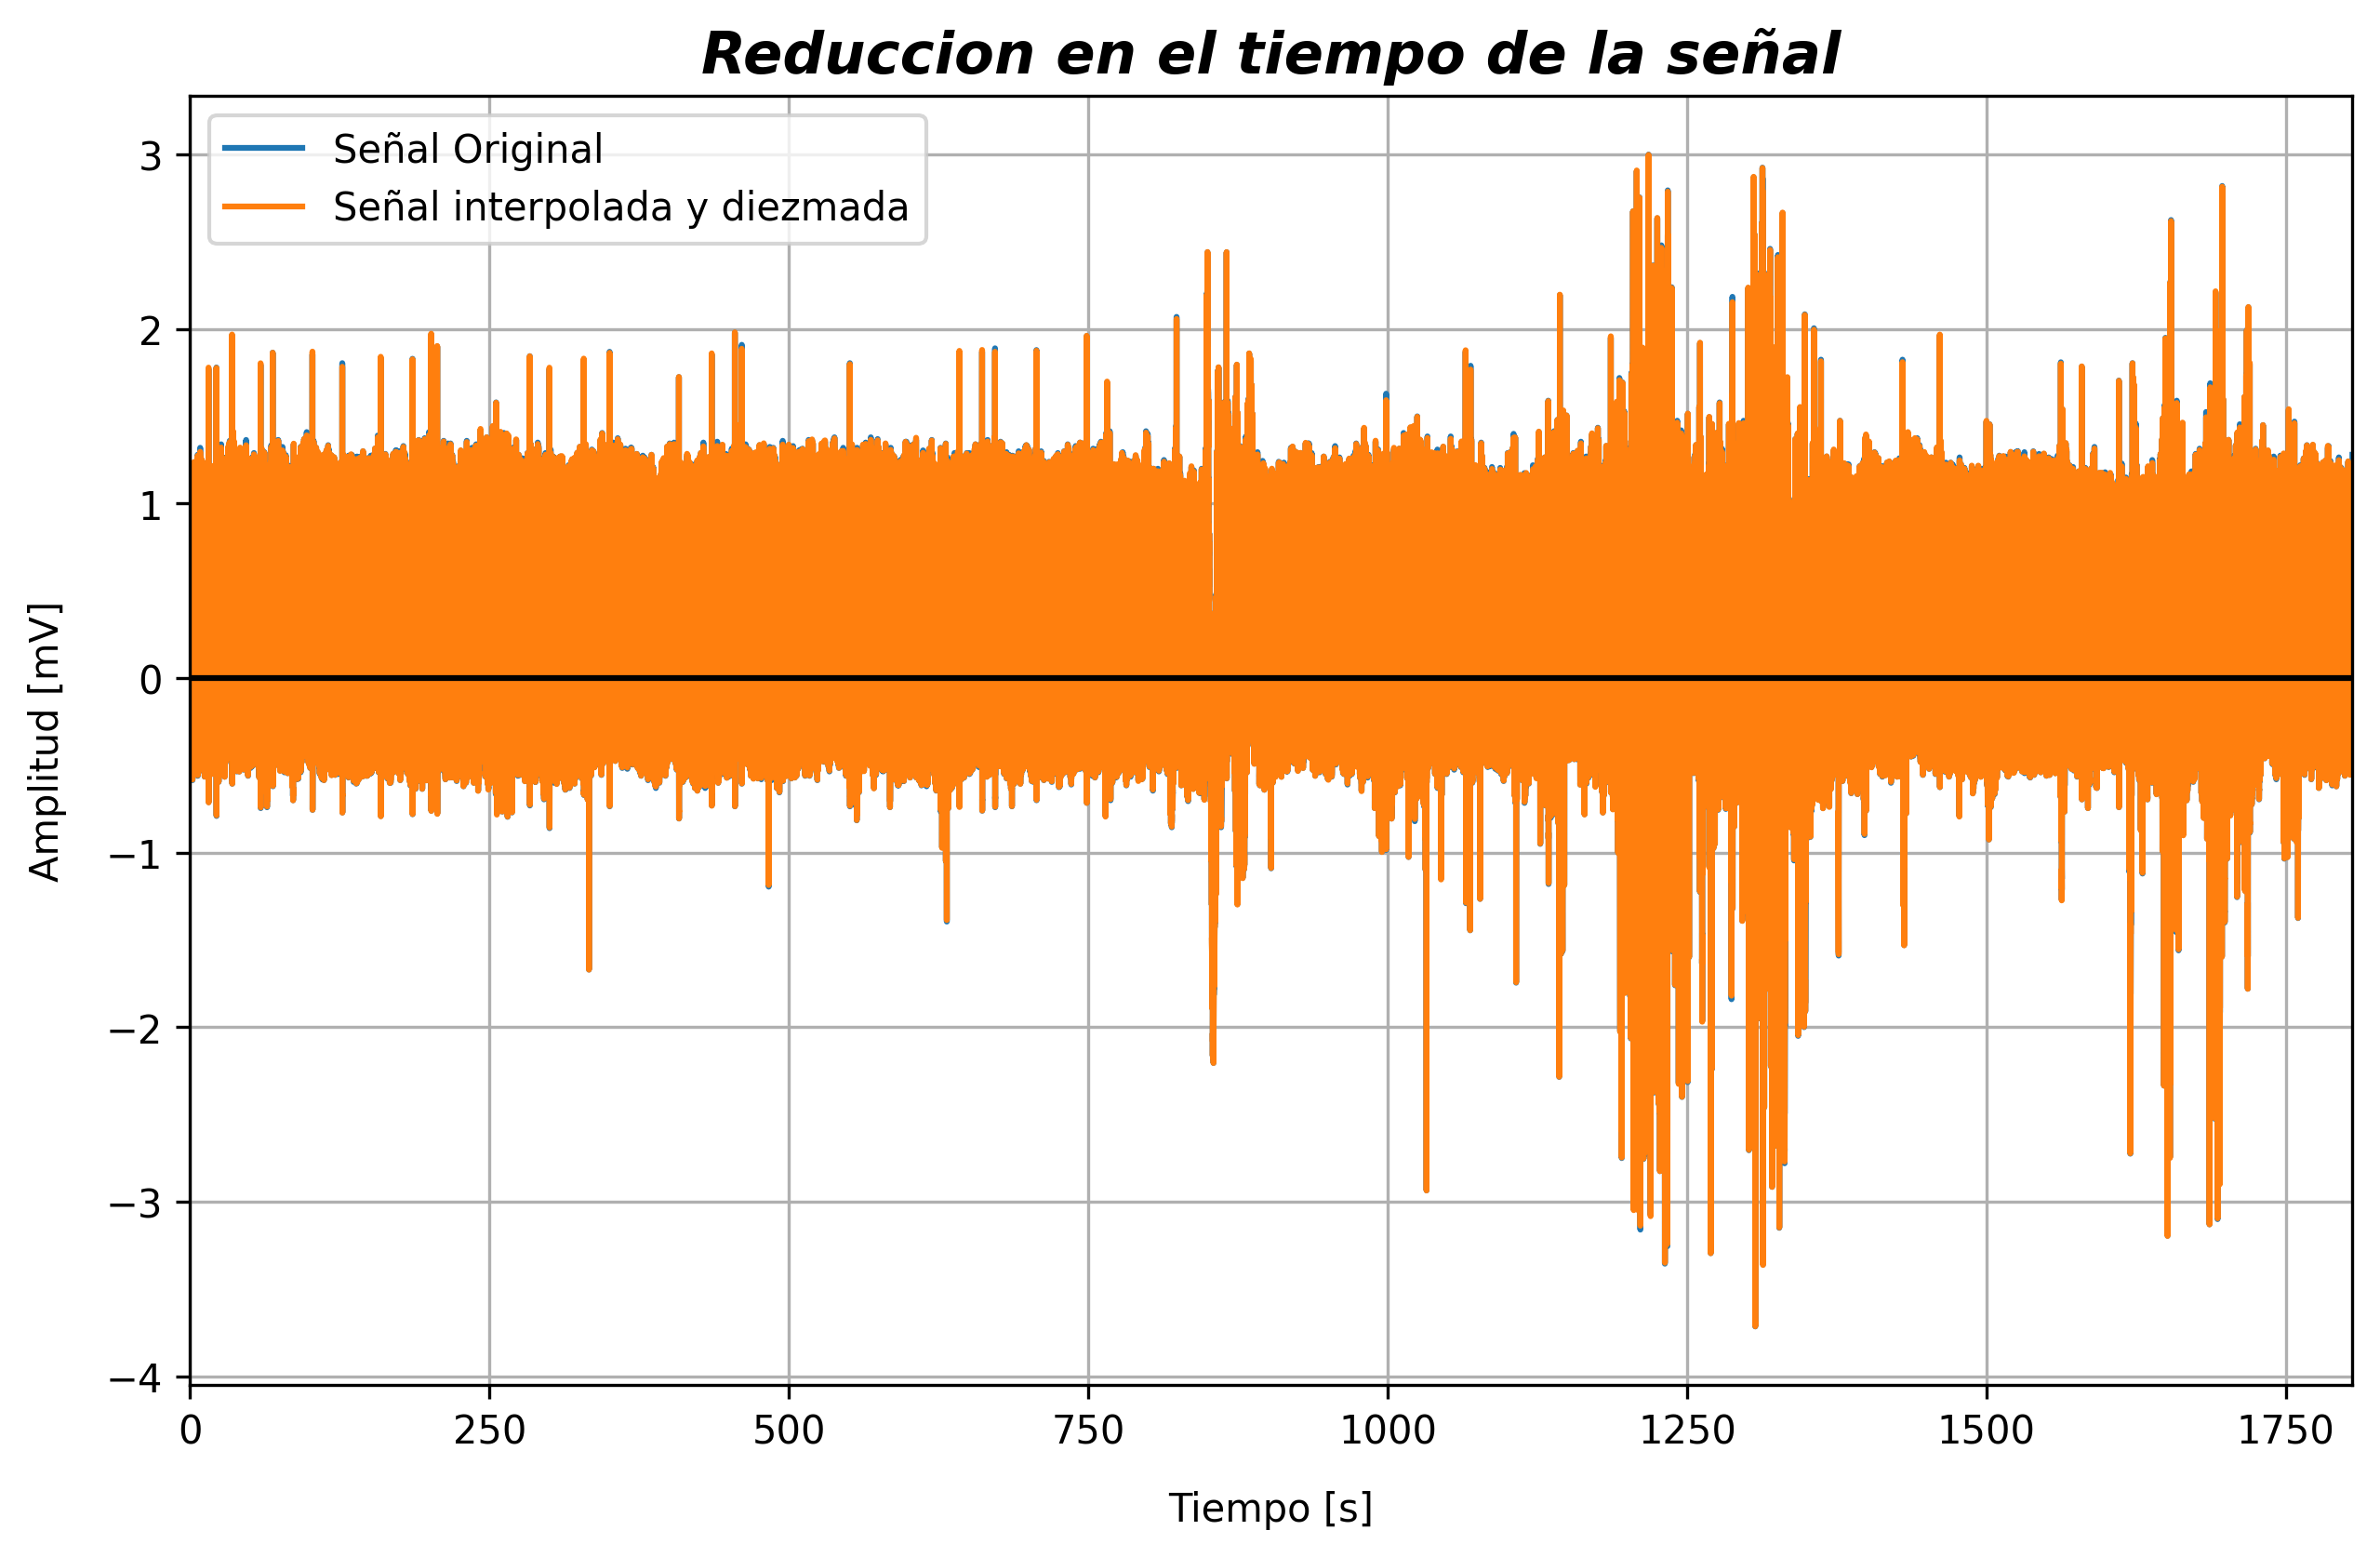

In [24]:
# Crea una figura y un eje para graficar las señales
fig = plt.figure(figsize=(10, 6), dpi=300)
ax = fig.add_subplot(111)
ax.set_title("Reduccion en el tiempo de la señal", weight='bold',fontsize=15, fontstyle='italic')
ax.set_xlabel("Tiempo [s]", labelpad=10)
ax.set_ylabel("Amplitud [mV]", labelpad=10)

# Grafica las dos señales en el eje
ax.plot(time1,senal_ecg_canal_I, label='Señal Original')
ax.plot(time2,senal_ecg_I_IntDiez, label='Señal interpolada y diezmada')

# Ajusta el ancho de la gráfica para que sea igual al de la señal
ax.set_xlim(min(time1), max(time1))

# Activa la cuadrícula en el eje
ax.grid(True)

# # Agrega una línea en x=0
# ax.axhline(y=0, color='black', linestyle='-')

# Agrega una leyenda
ax.legend()

# Muestra la gráfica
plt.savefig("ImagenesGuardadas\\IntDiezmado.png")
plt.show()

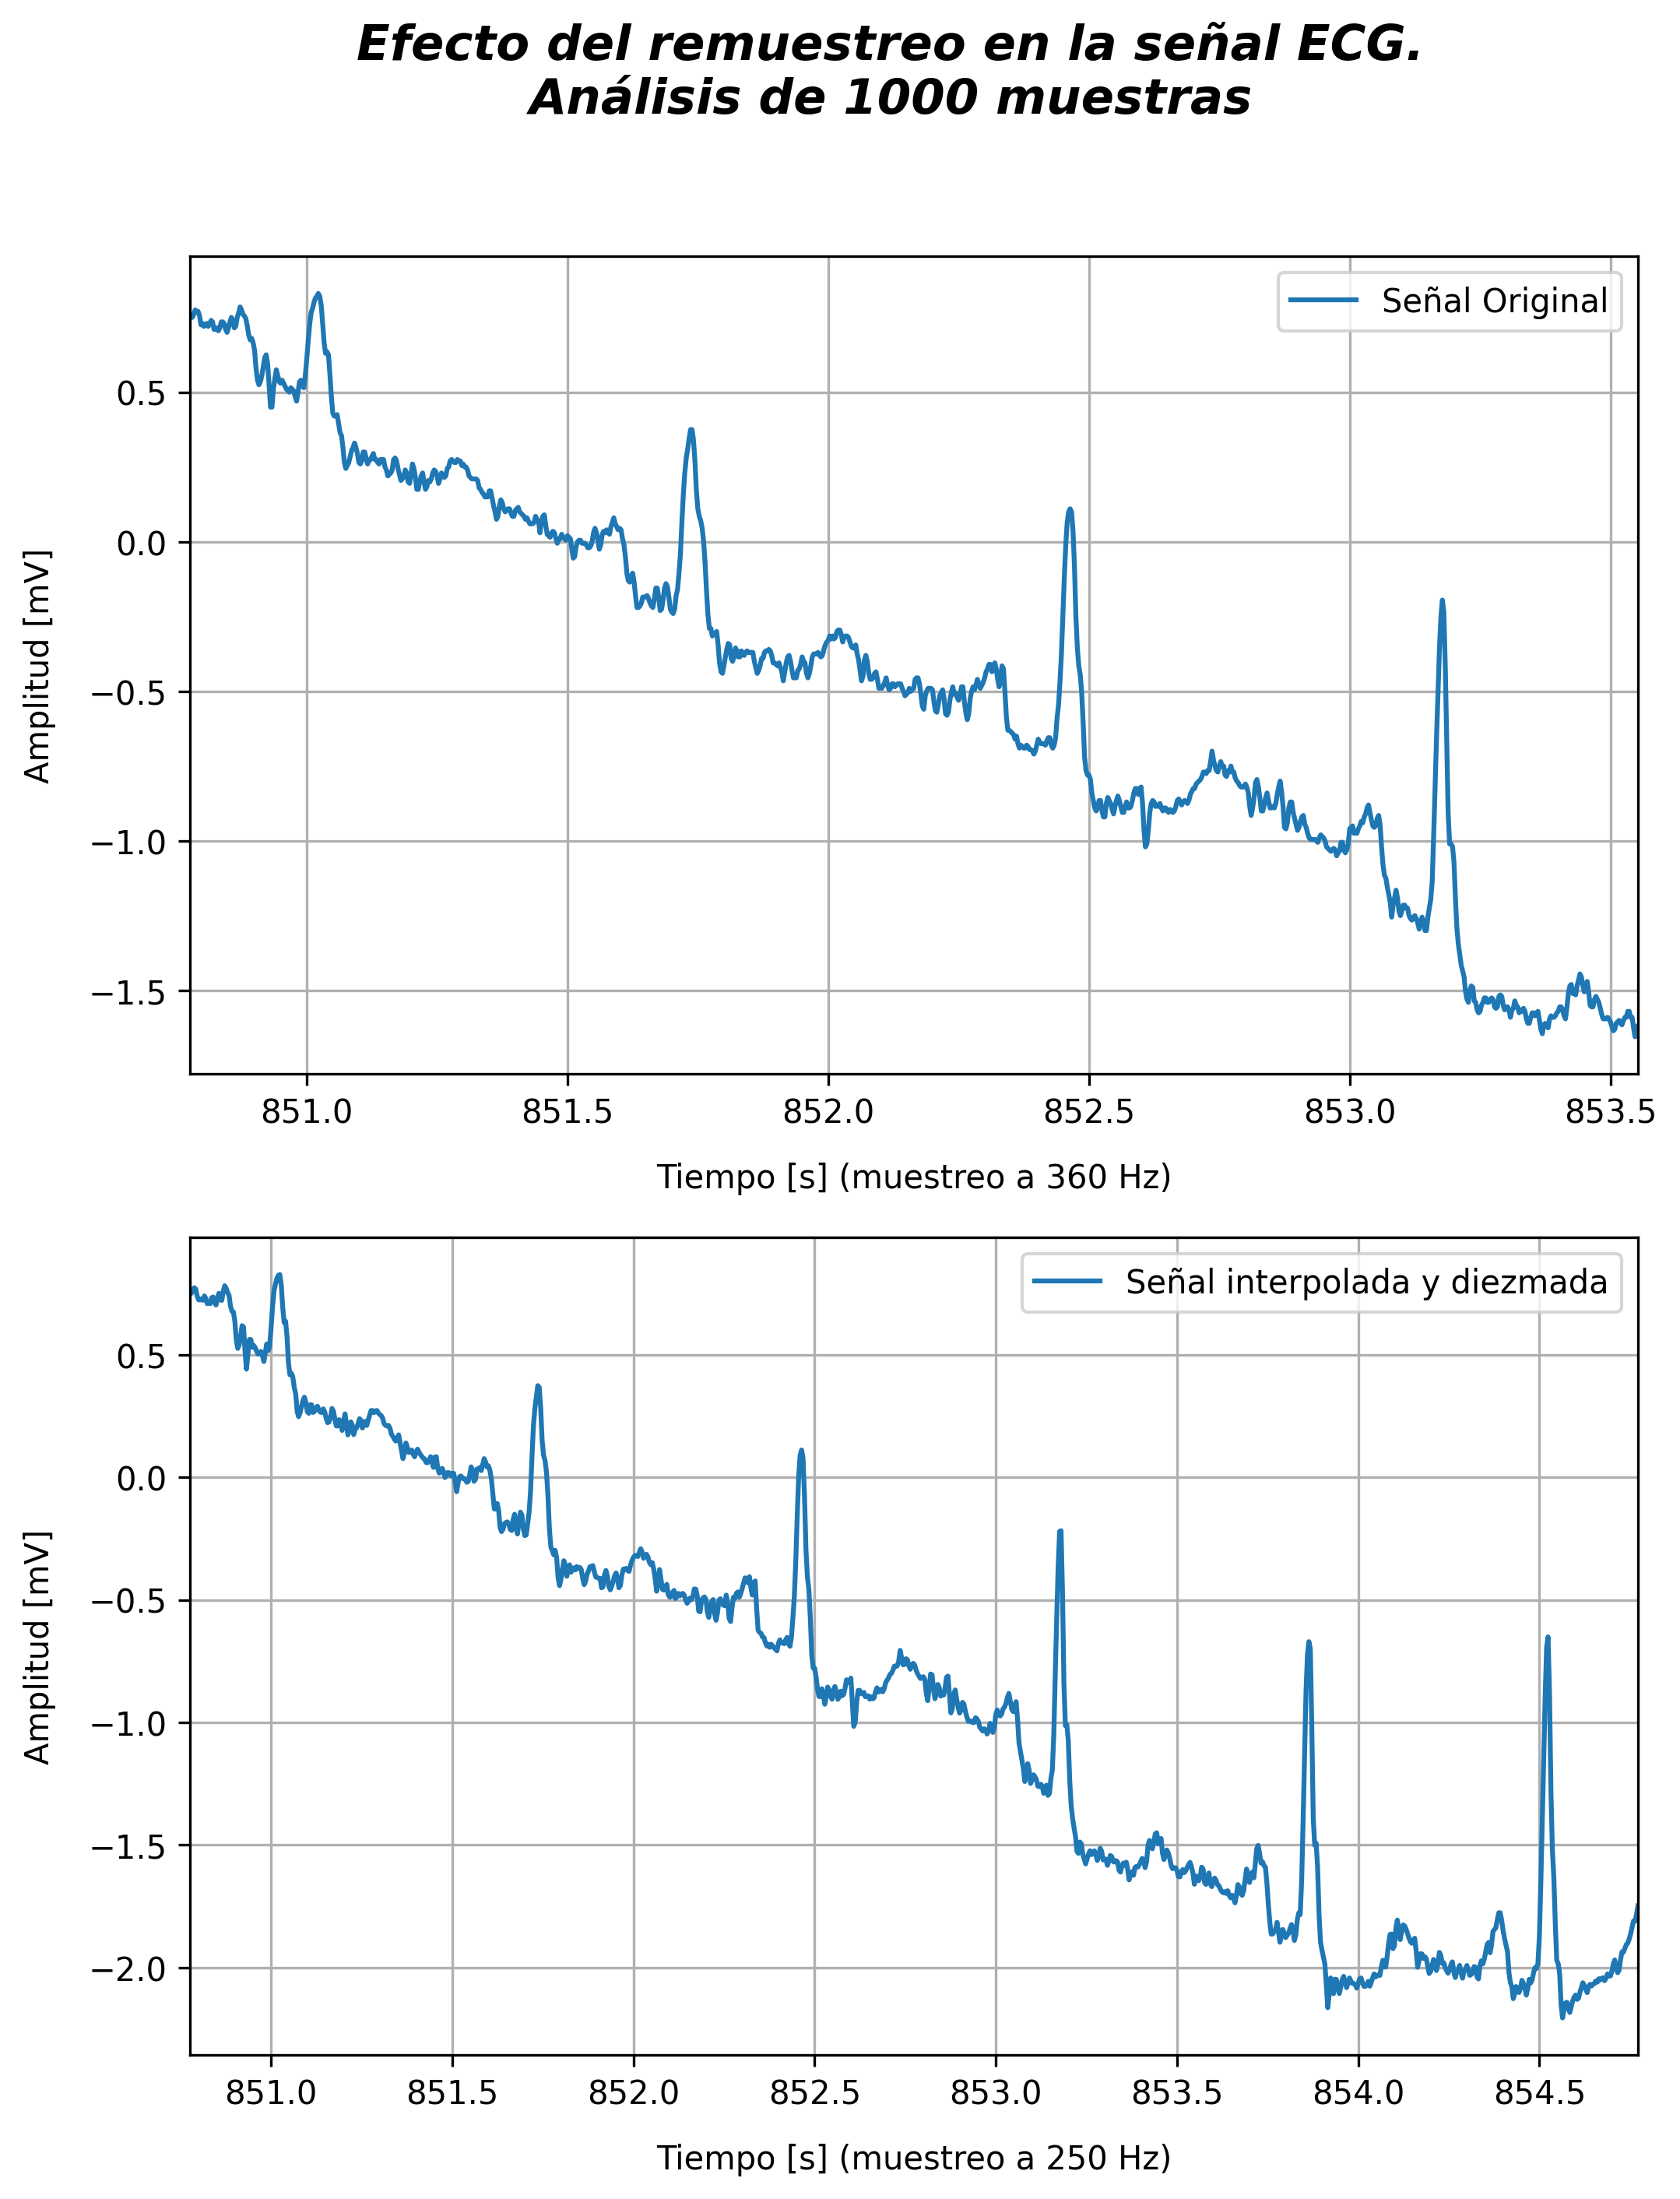

In [44]:
# Crea una figura y dos ejes para graficar las señales
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), dpi=300)
fig.suptitle("Efecto del remuestreo en la señal ECG.\nAnálisis de 1000 muestras", weight='bold', fontsize=15, fontstyle='italic')

# Configura el primer eje
ax1.set_xlabel("Tiempo [s] (muestreo a 360 Hz)", labelpad=10)
ax1.set_ylabel("Amplitud [mV]", labelpad=10)
ax1.plot(time1, senal_ecg_canal_I[306280:307280], label='Señal Original')
ax1.set_xlim(min(time2), max(time1))
ax1.grid(True)
ax1.legend()

# Configura el segundo eje
ax2.set_xlabel("Tiempo [s] (muestreo a 250 Hz)", labelpad=10)
ax2.set_ylabel("Amplitud [mV]", labelpad=10)
ax2.plot(time2, senal_ecg_I_IntDiez[212694:213694], label='Señal interpolada y diezmada')
ax2.set_xlim(min(time2), max(time2))
ax2.grid(True)
ax2.legend()

# Guarda y muestra la gráfica
plt.savefig("ImagenesGuardadas\\IntDiezmado.png")
plt.show()


In [ ]:
# Crea una figura y un eje para graficar las señales
fig = plt.figure(figsize=(10, 6), dpi=300)
ax = fig.add_subplot(111)
ax.set_title("Reduccion en el tiempo de la señal", weight='bold',fontsize=15, fontstyle='italic')
ax.set_xlabel("Tiempo [s]", labelpad=10)
ax.set_ylabel("Amplitud [mV]", labelpad=10)

# Grafica las dos señales en el eje
ax.plot(time1,senal_ecg_canal_I[CORTE_INF, CORTE_SUP], label='Señal Original')
ax.plot(time2,senal_ecg_I_IntDiez[CORTE_INF, CORTE_SUP], label='Señal interpolada y diezmada')

# Ajusta el ancho de la gráfica para que sea igual al de la señal
ax.set_xlim(min(time1), max(time1))

# Activa la cuadrícula en el eje
ax.grid(True)

# Agrega una línea en x=0
ax.axhline(y=0, color='black', linestyle='-')

# Agrega una leyenda
ax.legend()

# Muestra la gráfica
plt.savefig("ImagenesGuardadas\\IntDiezmado.png")
plt.show()

## Implementación del filtro de eliminación de ruido de linea base


In [7]:
def FIRRemoveBL(ecgy, Fs, Fc, factor):
    """ Funcion que define el filtro FIR
    ecgy: la señal contaminada (debe ser una lista)
    Fc: frecuencia de corte
    Fs: frecuencia de muestreo
    ECG_Clean : señal procesada sin ruido de linea base"""

    # Se obtiene el tamaño de la señal de entrada
    signal_len = len(ecgy)

    # La frecuencia de Nyquist de la señal.
    nyq_rate = Fs / 2.0

    # El ancho deseado de la transición de stop a pass,relativo a la tasa de Nyquist.
    width = 0.07/nyq_rate

    # Atenuación en la stopband del filtro, en dB.
    # relacionado con desarrolladores en Matlab. En Matlab está en proporción
    ripple_db = round(-20*np.log10(0.001))+1
    ripple_db = ripple_db / factor

    # Calcula el orden y el parámetro Kaiser para el filtro FIR.
    N, beta = kaiserord(ripple_db, width)

    # Uso de la funcion firwin con una ventana Kaiser para crear un filtro FIR de paso alto.
    h = firwin(N, Fc/nyq_rate, window=('kaiser', beta), pass_zero='highpass')

    # Comprobar la condición del filtro
    if N*3 > signal_len:
        diff = N*3 - signal_len
        ecgy = list(reversed(ecgy)) + list(ecgy) + \
            list(ecgy[-1] * np.ones(diff))

        # Filtrando con filtfilt
        # Esta función aplica un filtro digital lineal dos veces, una hacia adelante y otra hacia atrás.
        # El filtro combinado tiene fase cero y un orden de filtrado el doble que el original.
        ECG_Clean = filtfilt(h, 1.0, ecgy)
        ECG_Clean = ECG_Clean[signal_len: signal_len + signal_len]
    else:
        # Filtrando con filtfilt
        ECG_Clean = filtfilt(h, 1.0, ecgy)

    return ECG_Clean,N,h


In [8]:
# Filtrando la señal implementando la función:
ECG_FIR,N,fir_coef = FIRRemoveBL(senal_ecg_canal_I, FS, FC, FACTOR)

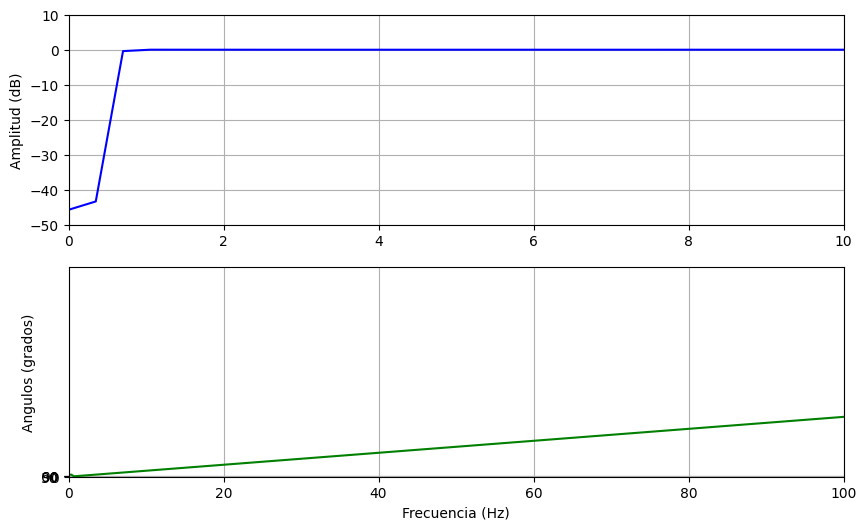

In [7]:
# Frequency response
freq, h = signal.freqz(fir_coef,fs=FS)
# Plot
fig, ax = plt.subplots(2, 1, figsize=(10, 6))
ax[0].plot(freq, 20*np.log10(abs(h)), color='blue')
ax[0].set_ylabel("Amplitud (dB)", color='black')
ax[0].set_xlim([0, 10])
ax[0].set_ylim([-50, 10])
ax[0].grid(True)
ax[1].plot(freq, np.unwrap(np.angle(h))*180/np.pi, color='green')
ax[1].set_ylabel("Angulos (grados)", color='black')
ax[1].set_xlabel("Frecuencia (Hz)")
ax[1].set_xlim([0, 100])
ax[1].set_yticks([-90, -60, -30, 0, 30, 60, 90])
ax[1].set_ylim([0,20000])
ax[1].grid(True)
plt.savefig("ImagenesGuardadas\\FiltroNotch.png",dpi=300)
plt.show()

### Comparando las dos señales

In [3]:
# Generando vector de tiempo
time=[]
for i in range(CORTE_INF,CORTE_SUP):
    time.append(i/360)# ya que son 360 muestras por segundo, escalo el rango anterior a su equivalente en segundos

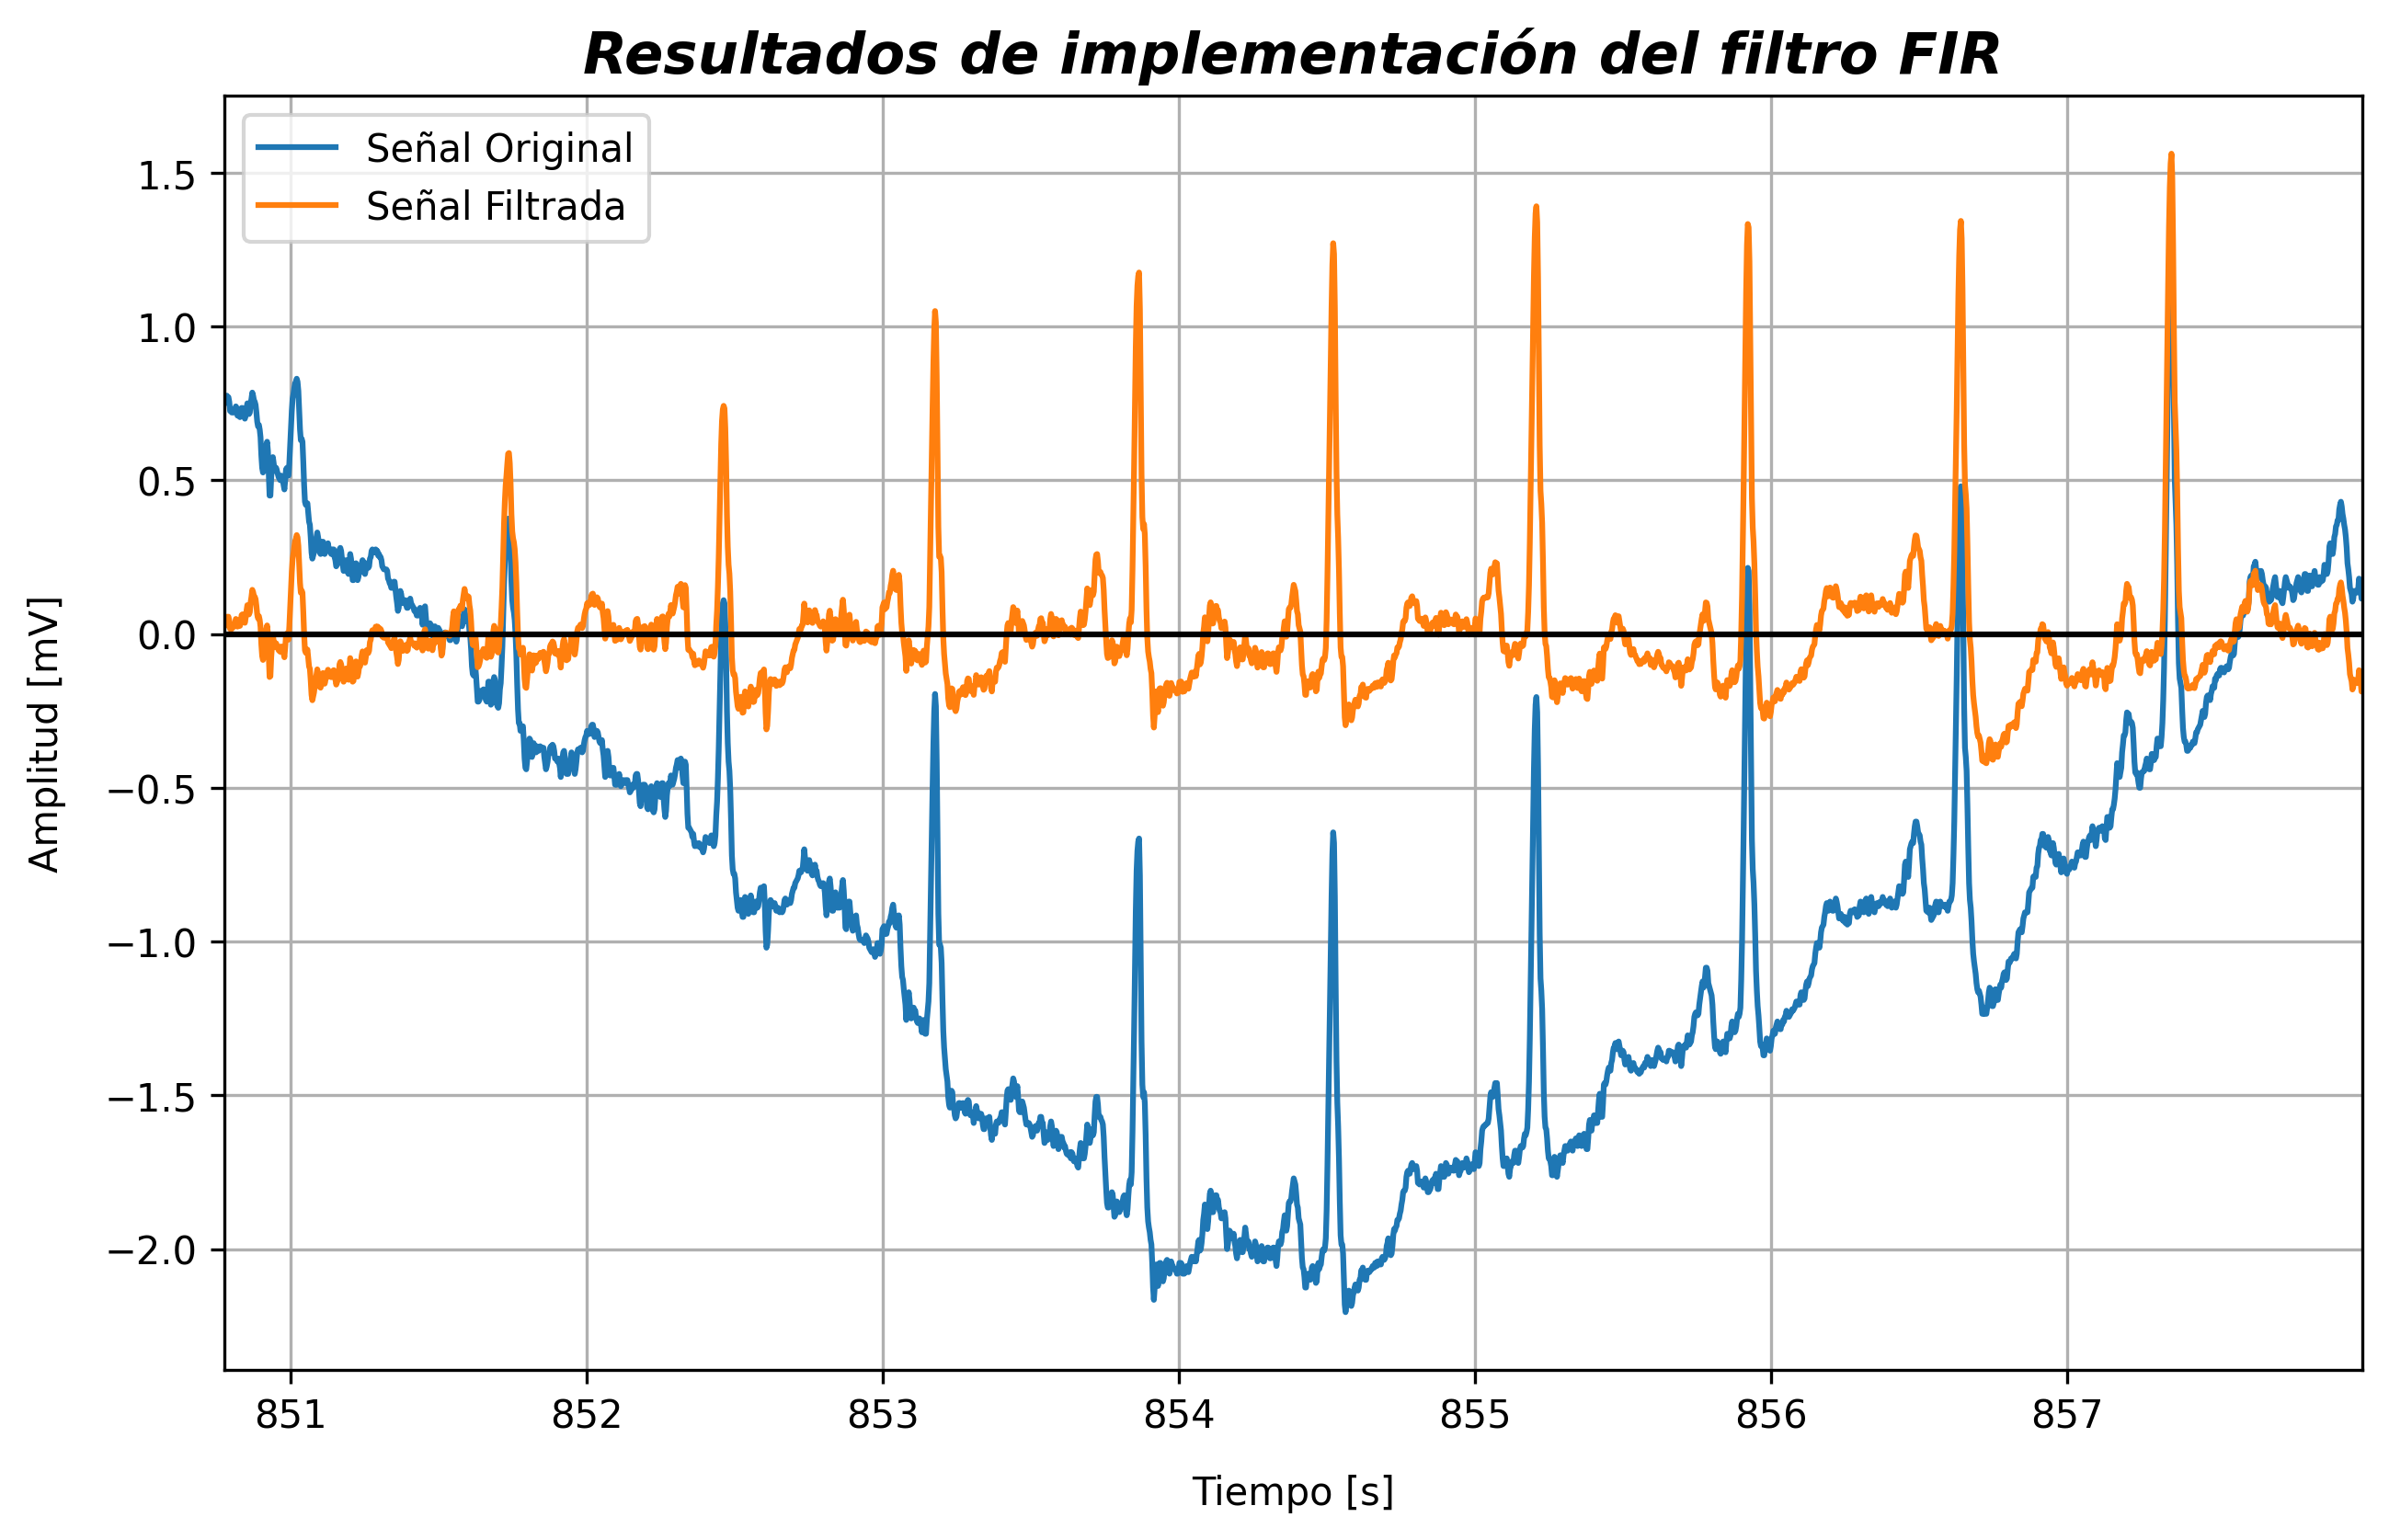

In [9]:
# Crea una figura y un eje para graficar las señales
fig = plt.figure(figsize=(10, 6), dpi=300)
ax = fig.add_subplot(111)
ax.set_title("Resultados de implementación del filtro FIR", weight='bold',fontsize=15, fontstyle='italic')
ax.set_xlabel("Tiempo [s]", labelpad=10)
ax.set_ylabel("Amplitud [mV]", labelpad=10)

# Grafica las dos señales en el eje
ax.plot(time,senal_ecg_canal_I[CORTE_INF:CORTE_SUP], label='Señal Original')
ax.plot(time,ECG_FIR[CORTE_INF:CORTE_SUP], label='Señal Filtrada')

# Ajusta el ancho de la gráfica para que sea igual al de la señal
ax.set_xlim(min(time), max(time))

# Activa la cuadrícula en el eje
ax.grid(True)

# ax.xaxis.set_major_locator(ticker.MultipleLocator(0.5))
# ax.yaxis.set_major_locator(ticker.MultipleLocator(0.5))
# ax.grid(which='both', axis='both', alpha=0.5, linewidth=0.5, linestyle=':')

# Agrega una línea en x=0
ax.axhline(y=0, color='black', linestyle='-')

# Agrega una leyenda
ax.legend()

# Muestra la gráfica
plt.savefig("ImagenesGuardadas\\FiltroFIR.png")
plt.show()


## Implementación del filtro pasa bajas

In [10]:
def butter_lowpass(cutoff, fs, order=5):
    return butter(order, cutoff, fs=fs, btype='low', analog=False)

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [11]:
pasobajoECG=butter_lowpass_filter(ECG_FIR,150,FS,order=6)#Se filtra el primer canal de la señal Frecuencia de corte = 4500 Hz
# Generando vector de tiempo
time=[]
for i in range(CORTE_INF2,CORTE_SUP2):
    time.append(i/360)# ya que son 360 muestras por segundo, escalo el rango anterior a su equivalente en segundos

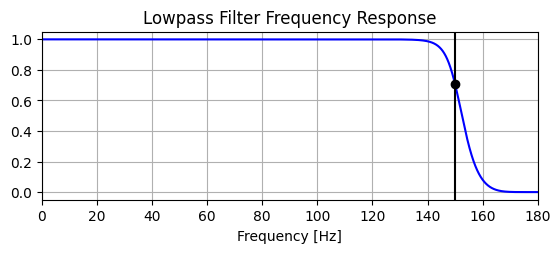

In [12]:
# Plot the frequency response.
b, a = butter_lowpass(150, FS, order=6)
w, h = freqz(b, a, fs=FS, worN=8000)
plt.subplot(2, 1, 1)
plt.plot(w, np.abs(h), 'b')
plt.plot(150, 0.5*np.sqrt(2), 'ko')
plt.axvline(150, color='k')
plt.xlim(0, 0.5*FS)
plt.title("Lowpass Filter Frequency Response")
plt.xlabel('Frequency [Hz]')
plt.grid()


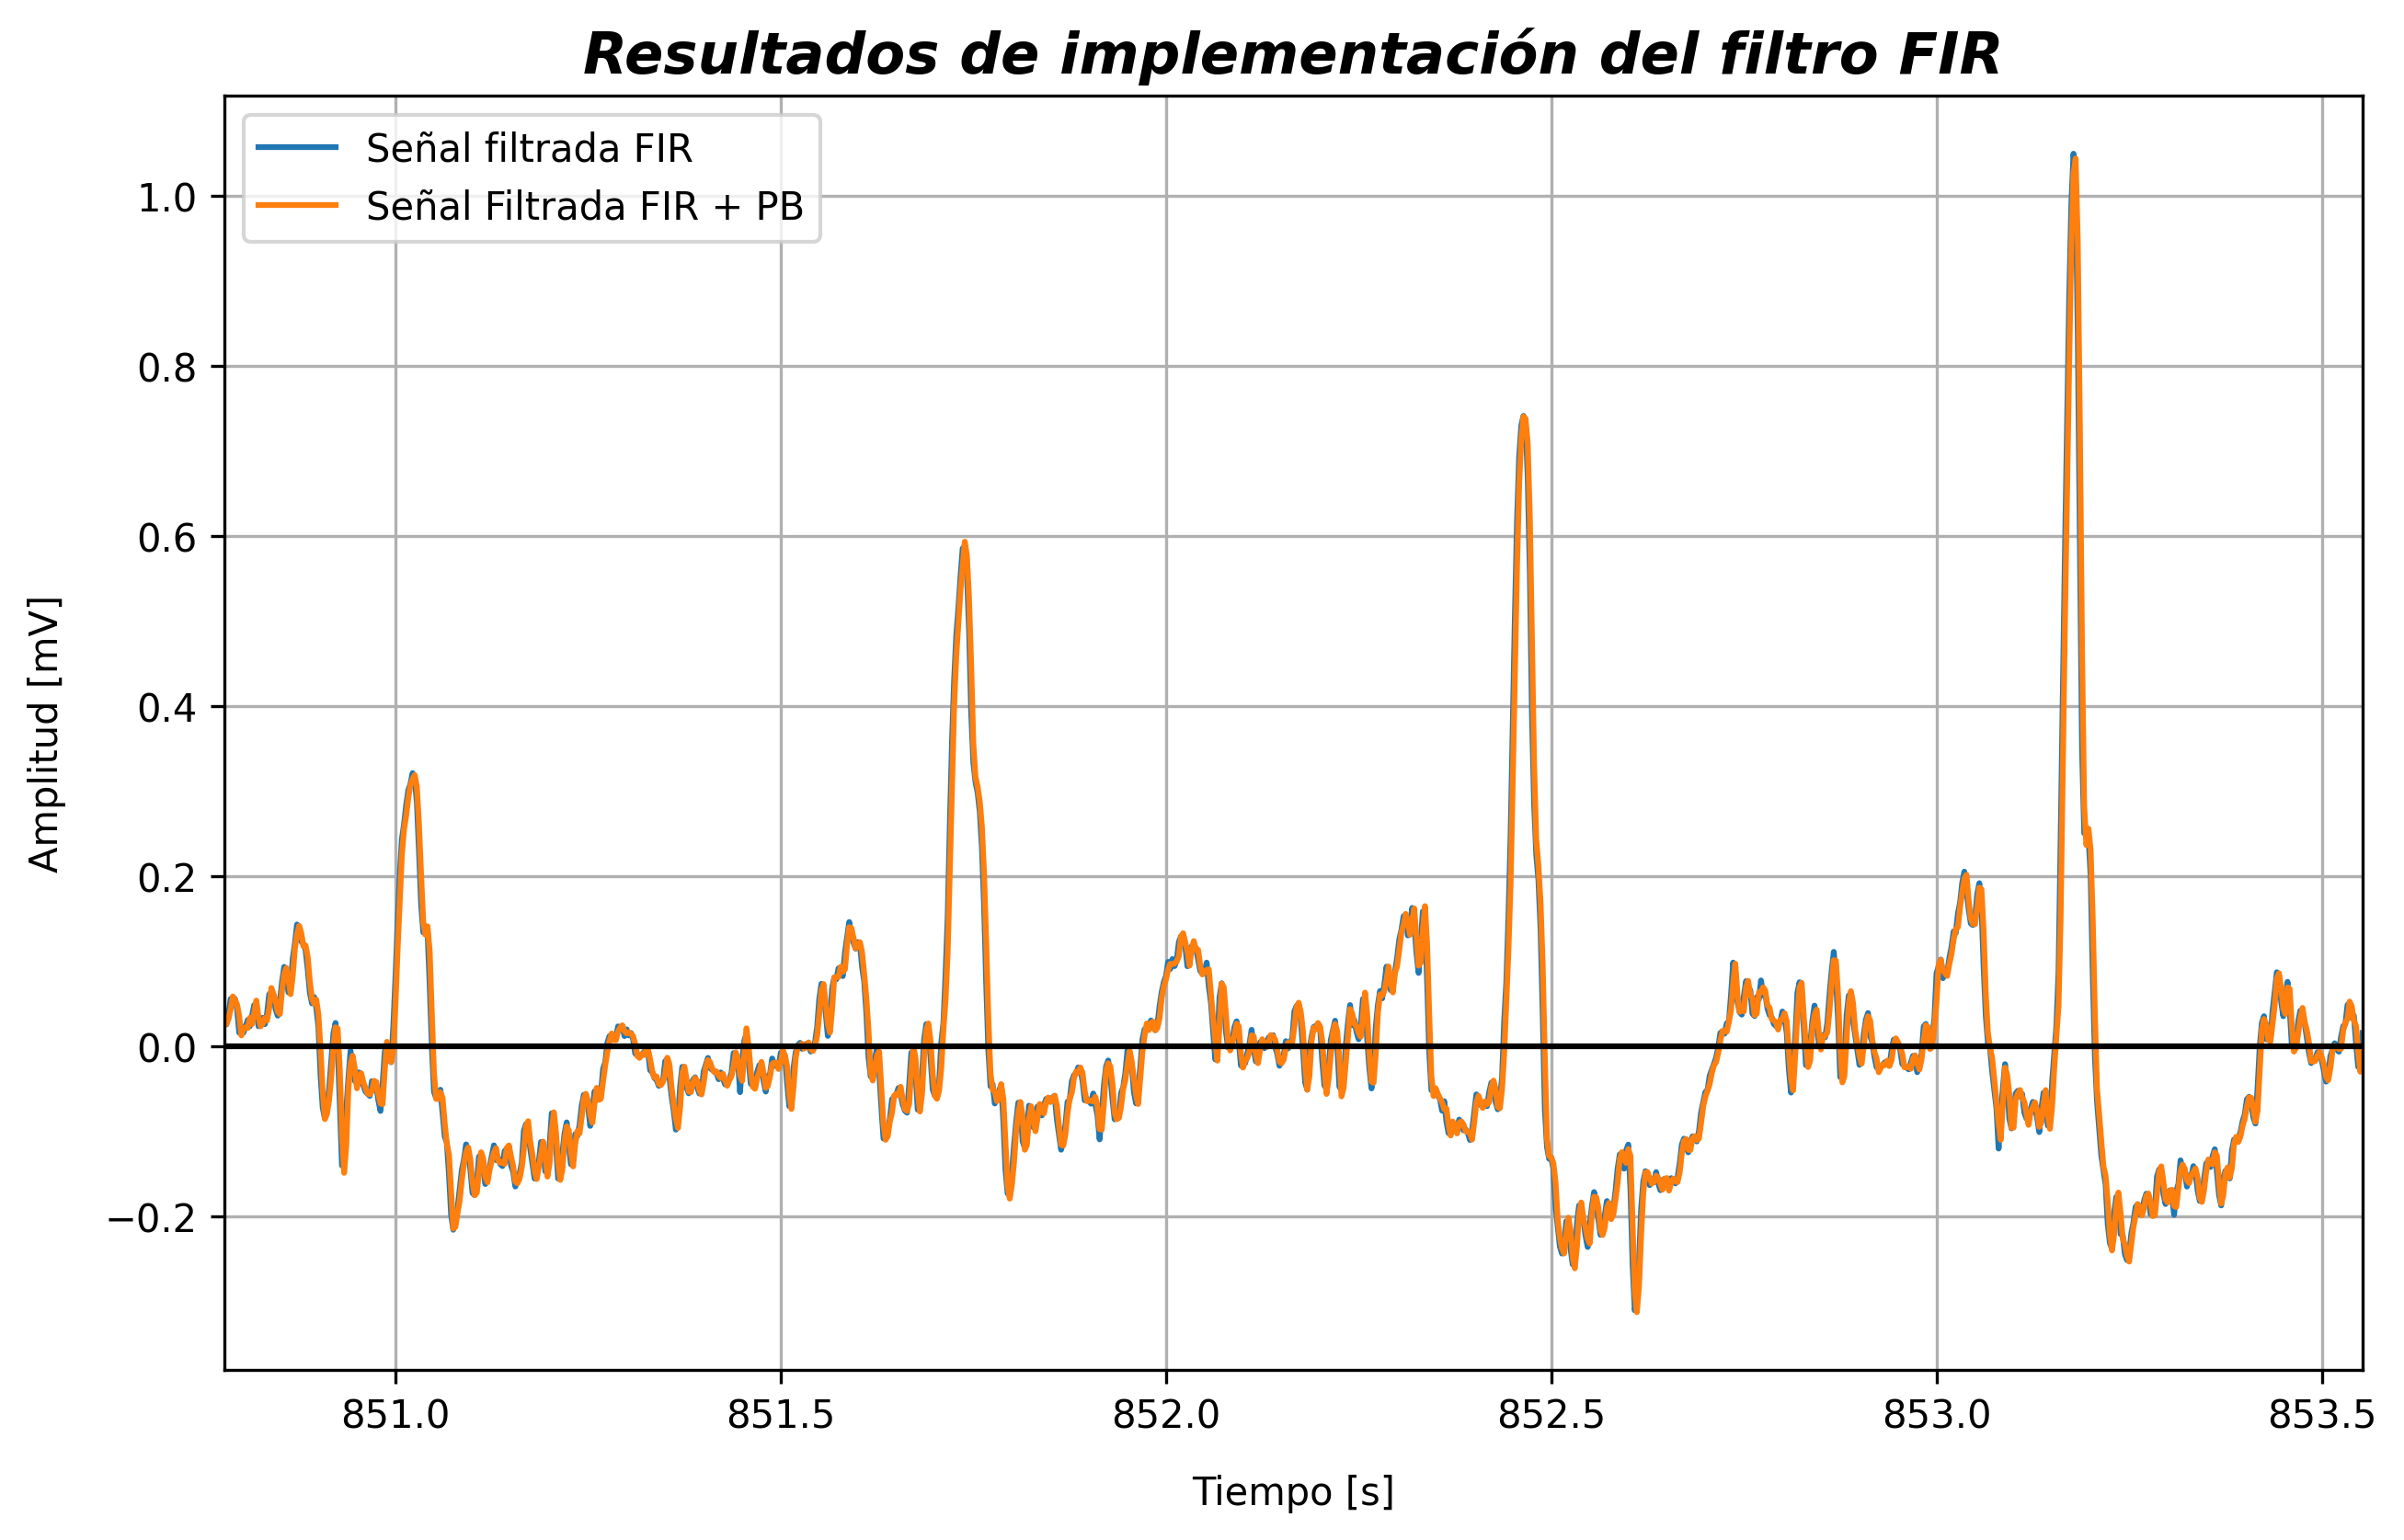

In [13]:
# Crea una figura y un eje para graficar las señales
fig = plt.figure(figsize=(10, 6), dpi=300)
ax = fig.add_subplot(111)
ax.set_title("Resultados de implementación del filtro FIR", weight='bold',fontsize=15, fontstyle='italic')
ax.set_xlabel("Tiempo [s]", labelpad=10)
ax.set_ylabel("Amplitud [mV]", labelpad=10)

# Grafica las dos señales en el eje
ax.plot(time,ECG_FIR[CORTE_INF2:CORTE_SUP2], label='Señal filtrada FIR')
ax.plot(time,pasobajoECG[CORTE_INF2:CORTE_SUP2], label='Señal Filtrada FIR + PB')


# Ajusta el ancho de la gráfica para que sea igual al de la señal
ax.set_xlim(min(time), max(time))

# Activa la cuadrícula en el eje
ax.grid(True)

# ax.xaxis.set_major_locator(ticker.MultipleLocator(0.5))
# ax.yaxis.set_major_locator(ticker.MultipleLocator(0.5))
# ax.grid(which='both', axis='both', alpha=0.5, linewidth=0.5, linestyle=':')

# Agrega una línea en x=0
ax.axhline(y=0, color='black', linestyle='-')

# Agrega una leyenda
ax.legend()

# Muestra la gráfica
plt.savefig("ImagenesGuardadas\\FiltroFIR.png")
plt.show()


## Implementación del filtro notch

In [14]:
notch_freq= 60 # Hz
quality_factor=20.0
b_notch, a_notch = signal.iirnotch(notch_freq, quality_factor, FS)
ECG_Notch = signal.filtfilt(b_notch, a_notch, ECG_FIR)
    

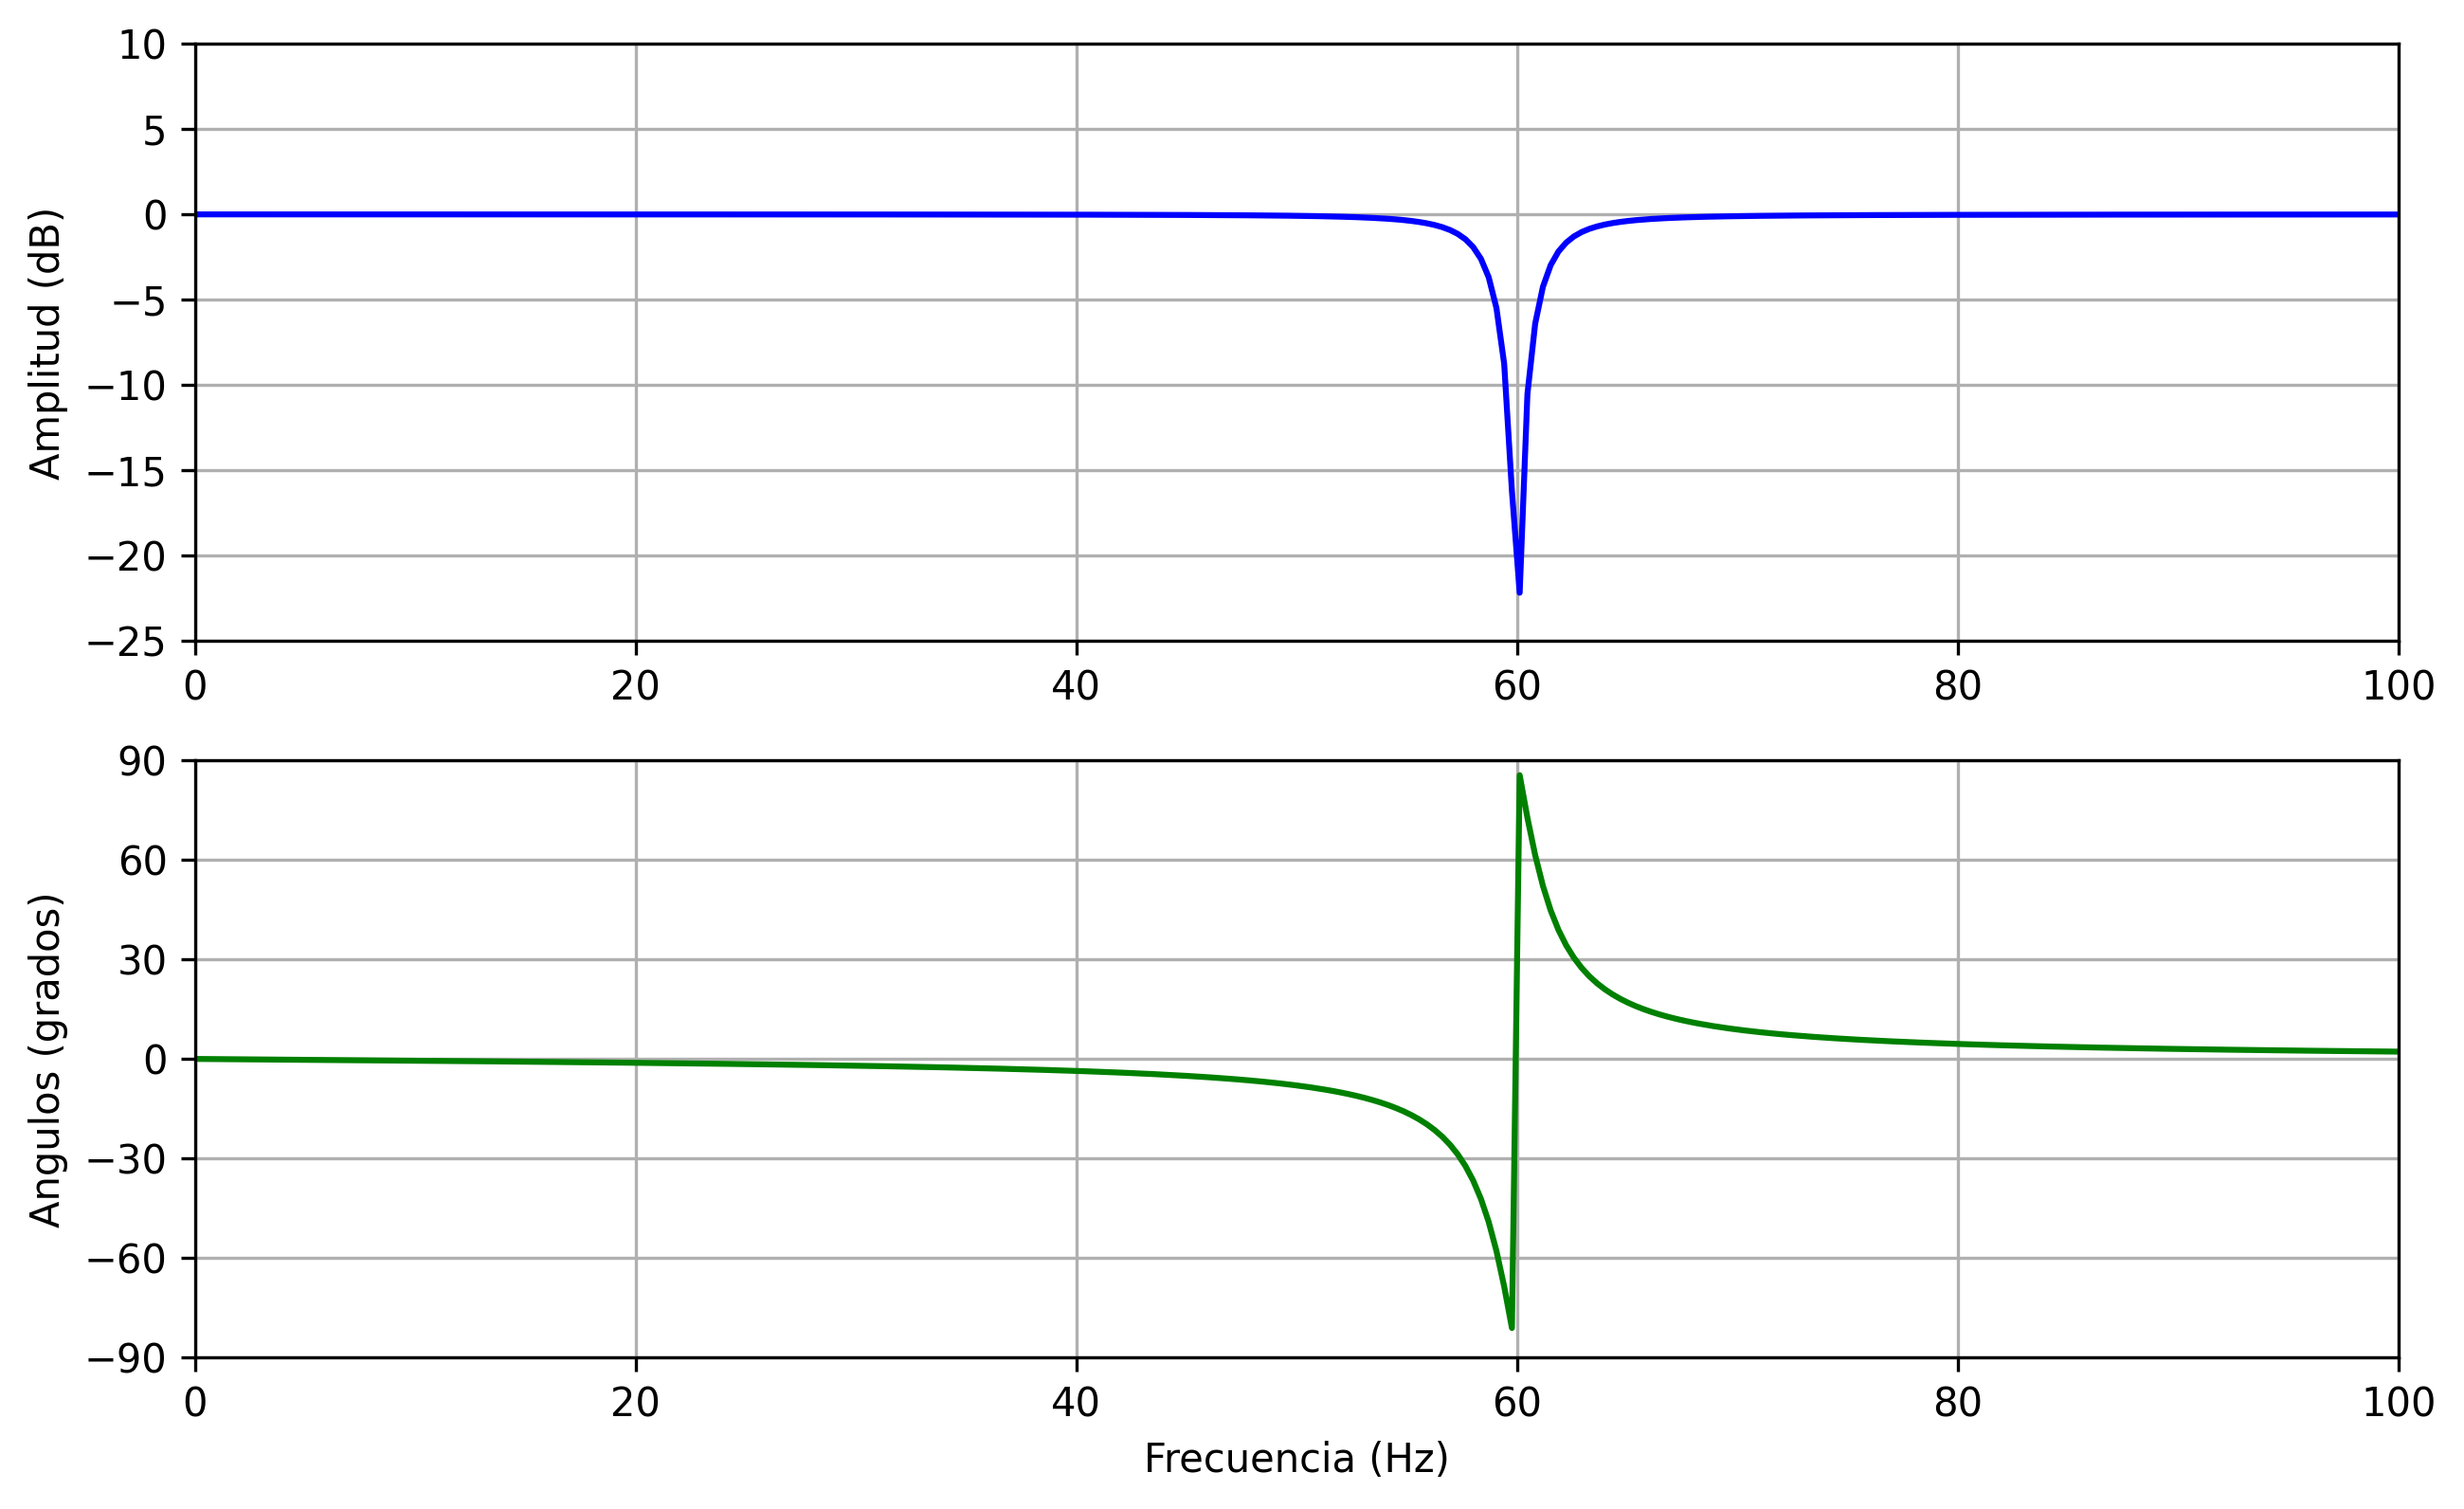

In [15]:
# Frequency response
freq, h = signal.freqz(b_notch, a_notch, fs=FS)
# Plot
fig, ax = plt.subplots(2, 1, figsize=(10, 6),dpi=300)
ax[0].plot(freq, 20*np.log10(abs(h)), color='blue')
ax[0].set_ylabel("Amplitud (dB)", color='black')
ax[0].set_xlim([0, 100])
ax[0].set_ylim([-25, 10])
ax[0].grid(True)
ax[1].plot(freq, np.unwrap(np.angle(h))*180/np.pi, color='green')
ax[1].set_ylabel("Angulos (grados)", color='black')
ax[1].set_xlabel("Frecuencia (Hz)")
ax[1].set_xlim([0, 100])
ax[1].set_yticks([-90, -60, -30, 0, 30, 60, 90])
ax[1].set_ylim([-90, 90])
ax[1].grid(True)
plt.savefig("ImagenesGuardadas\\FiltroNotch.png",dpi=300)
plt.show()

In [16]:
MAD(senal_ecg_canal_I,ECG_FIR)

1.9319673198748397

# Factor de Calidad

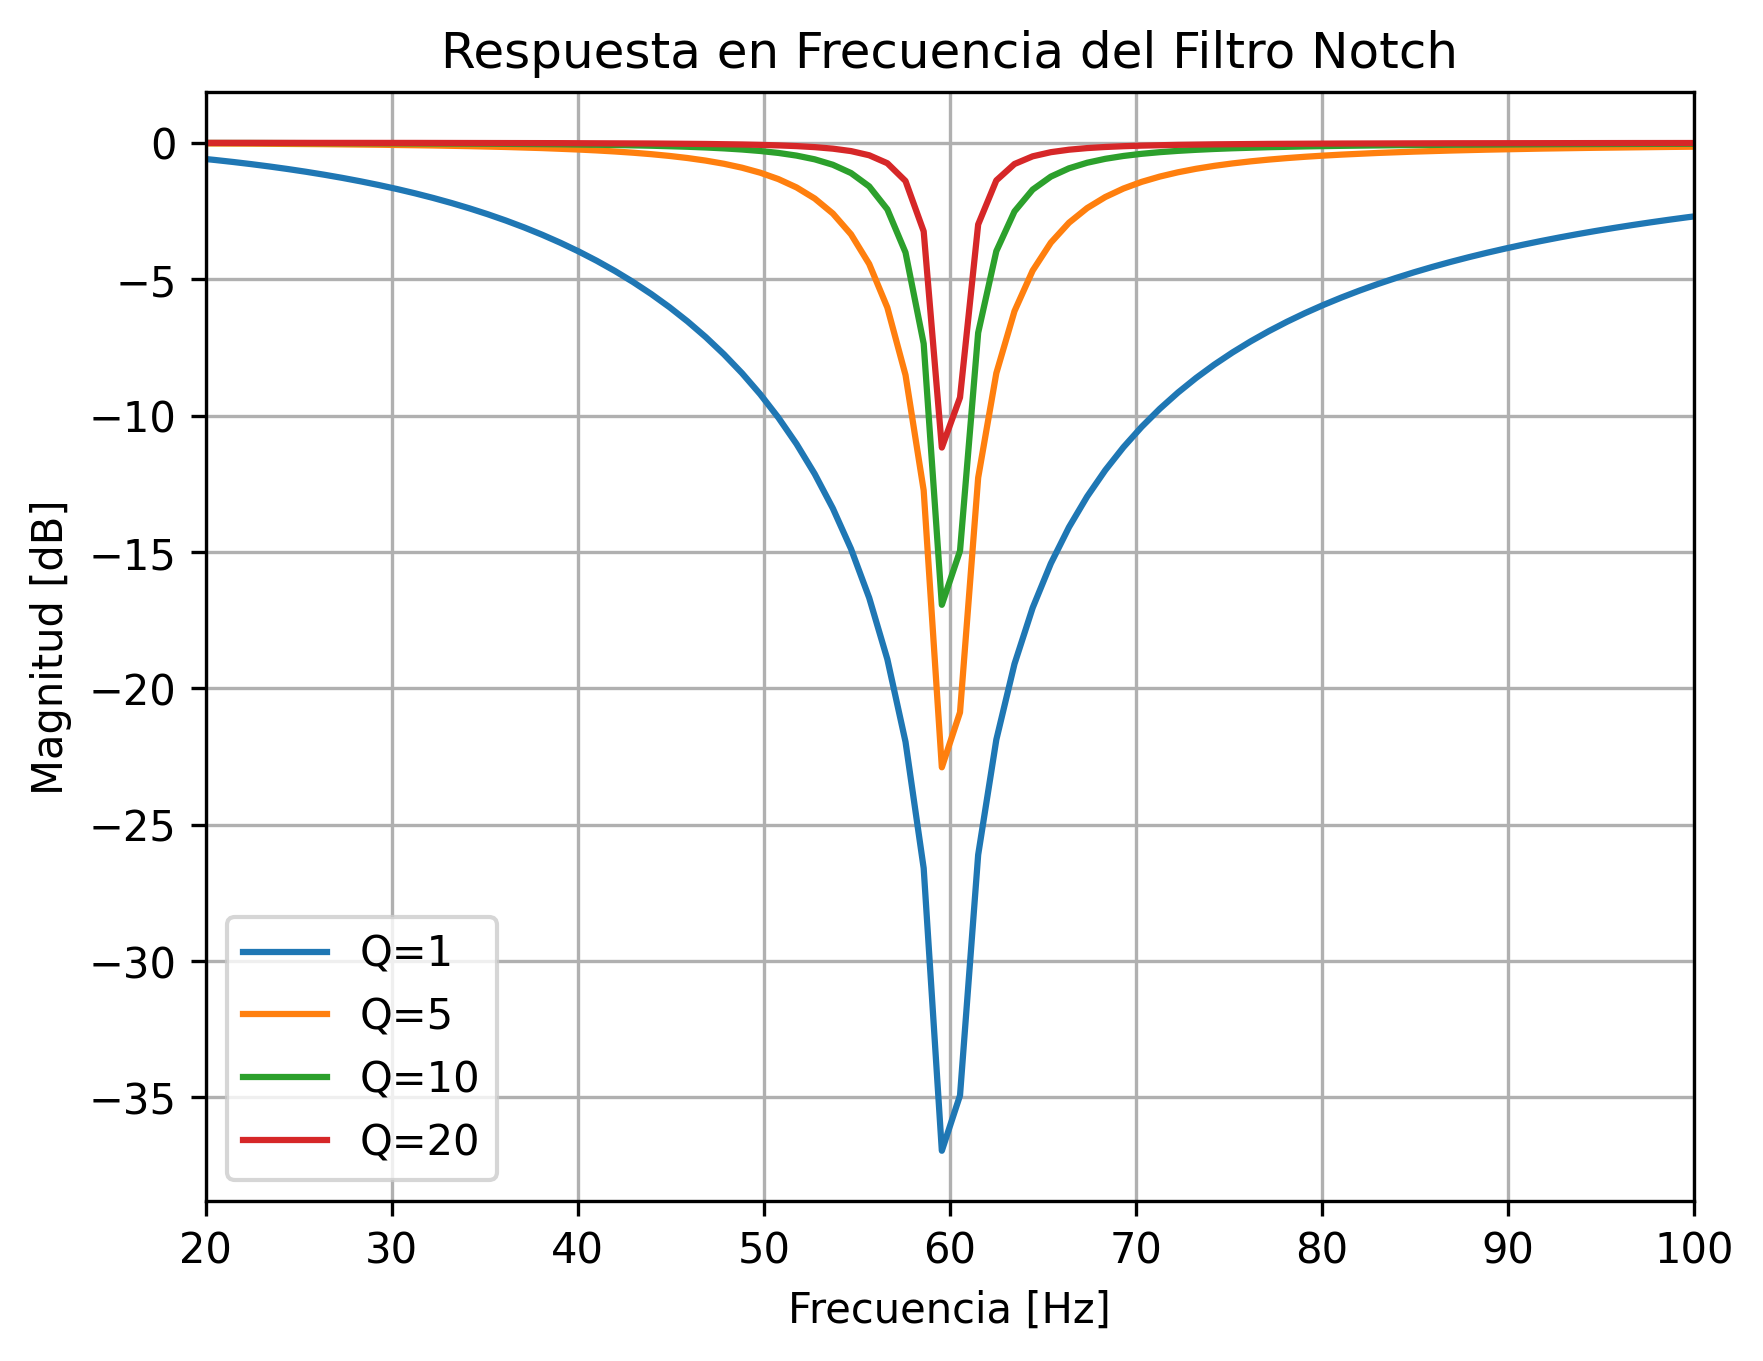

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

# Definir los parámetros del filtro notch
fs = 1000  # Frecuencia de muestreo
f0 = 60  # Frecuencia central del notch
Q = 1  # Factor de calidad inicial

# Generar el filtro notch con el factor de calidad inicial
b, a = signal.iirnotch(f0, Q, fs)

# Calcular la respuesta en frecuencia del filtro notch
w, h = signal.freqz(b, a)

# Graficar la respuesta en frecuencia del filtro notch
fig, ax = plt.subplots(dpi=300)
ax.plot(w / np.pi * fs / 2, 20 * np.log10(abs(h)), label=f'Q={Q}')

# Variar el factor de calidad y graficar la respuesta en frecuencia correspondiente
for Q in [5, 10, 20]:
    b, a = signal.iirnotch(f0, Q, fs)
    w, h = signal.freqz(b, a)
    ax.plot(w / np.pi * fs / 2, 20 * np.log10(abs(h)), label=f'Q={Q}')

# Definir los límites del eje x
ax.set_xlim([20, 100])

# Configurar la gráfica
ax.set_xlabel('Frecuencia [Hz]')
ax.set_ylabel('Magnitud [dB]')
ax.set_title('Respuesta en Frecuencia del Filtro Notch')
ax.legend()
ax.grid(True)

#Guardar figura
plt.savefig("ImagenesGuardadas\\FactordeCalidad.png",dpi=300)

# Mostrar la gráfica
plt.show()

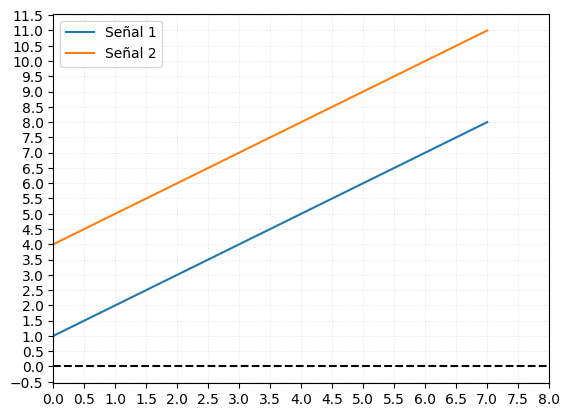

In [18]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Genera datos de ejemplo para las dos señales
signal1 = [1, 2, 3, 4, 5, 6, 7, 8]
signal2 = [4, 5, 6, 7, 8, 9, 10, 11]

# Crea una figura y un eje para graficar las señales
fig, ax = plt.subplots()

# Grafica las dos señales en el eje
ax.plot(signal1, label='Señal 1')
ax.plot(signal2, label='Señal 2')

# Activa la cuadrícula en el eje con distancia entre líneas personalizadas
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.5))
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.5))
ax.grid(which='both', axis='both', alpha=0.5, linewidth=0.5, linestyle=':')

# Agrega una línea en y=0
ax.axhline(y=0, color='black', linestyle='--')

# Ajusta el ancho de la gráfica para que sea igual al de la señal
ax.set_xlim(0, max(len(signal1), len(signal2)))

# Agrega una leyenda
ax.legend()

# Muestra la gráfica
plt.show()


## ventaneo y generación de espectrogramas

In [5]:
import numpy as np  #Calculos
import pandas as pd
from scipy import signal #Para la implementación defiltros
from scipy.signal import filtfilt, butter, kaiserord, lfilter, firwin , resample_poly#Filtros
from matplotlib import mlab
import matplotlib.pyplot as plt #Para graficar señales
import wfdb # Tratar BD MIT

In [6]:
def FIRRemoveBL(ecgy, Fs, Fc, factor):
    
    """ Funcion que define el filtro FIR
    ecgy: la señal contaminada (debe ser una lista)
    Fc: frecuencia de corte
    Fs: frecuencia de muestreo
    ECG_Clean : señal procesada sin ruido de linea base"""
    
    # Se obtiene el tamaño de la señal de entrada
    signal_len = len(ecgy)
    
    # La frecuencia de Nyquist de la señal.
    nyq_rate = Fs / 2.0
    
    # El ancho deseado de la transición de stop a pass,relativo a la tasa de Nyquist.
    width = 0.07/nyq_rate 
    
    # Atenuación en la stopband del filtro, en dB.
    # relacionado con desarrolladores en Matlab. En Matlab está en proporción
    ripple_db = round(-20*np.log10(0.001))+1
    ripple_db = ripple_db / factor

    
    # Calcula el orden y el parámetro Kaiser para el filtro FIR.
    N, beta = kaiserord(ripple_db, width)
       
    # Uso de la funcion firwin con una ventana Kaiser para crear un filtro FIR de paso alto.
    h = firwin(N, Fc/nyq_rate, window=('kaiser', beta), pass_zero='highpass')

    # Comprobar la condición del filtro
    if N*3 > signal_len:
        diff = N*3 - signal_len
        ecgy = list(reversed(ecgy)) + list(ecgy) + list(ecgy[-1] * np.ones(diff))
        
        # Filtrando con filtfilt
        # Esta función aplica un filtro digital lineal dos veces, una hacia adelante y otra hacia atrás. 
        # El filtro combinado tiene fase cero y un orden de filtrado el doble que el original.
        ECG_Clean = filtfilt(h, 1.0, ecgy)
        ECG_Clean = ECG_Clean[signal_len: signal_len + signal_len]
    else:
        # Filtrando con filtfilt
        ECG_Clean = filtfilt(h, 1.0, ecgy)
    
    return ECG_Clean, N
def rangos_ventaneo_senal(fs,tam_seg,rango):
    """Esta funcion es para generar los rangos de las ventanas de la señal a ventanear"""
    #Calculo el tamaño de la ventana 
    ventana=tam_seg*fs
    
    #Calculo los numeros iniciales de cada rango de ventanas, en este caso el paso será de la mitad del tamaño de la ventana, porque haremos un solapamiento del 50%
    ini_ran_ventanas=np.arange(rango[0],rango[1]-int(ventana/2),int(ventana/2))
    
    #Genero un arreglo con numeros de 0 hasta el tamaño de la ventana
    idx=np.arange(0,ventana)
    
    #Genero un vector columna donde cada numero representa el inicio de cada ventana que será aplicada a la señal
    inicios_ventana_vectorcolumna=ini_ran_ventanas[:,np.newaxis]
    
    #Sumo cada uno de los inicios anteriores, a un vector que va desde 0 a hasta el tamaño maximo de la ventana para generar los rangos necesarios
    ran_ventaneo=inicios_ventana_vectorcolumna+idx[np.newaxis,:]
    #Verifico si las ventanas están dentro del rango
    if ran_ventaneo[-1][-1]>rango[1]:
         ran_ventaneo=np.delete(ran_ventaneo,-1,axis=0)
    return  ran_ventaneo
def graph_spectrogram(ecg,fs):
    """Esta función extrae la matriz de datos del espectrograma de la señal"""
    
    nfft = 100 # Length of each window segment
    noverlap = 90 # Overlap between windows
    nchannels = ecg.ndim
    if nchannels == 1:
        pxx, freqs, bins, im = plt.specgram(ecg, nfft, fs, noverlap = noverlap)
    elif nchannels == 2:
        pxx, freqs, bins, im = plt.specgram(ecg[:,0], nfft, fs, noverlap = noverlap)
    return pxx
def funcion_filtro_normalizacion_FA(paciente,data_path,Fs,resample=False):
    """Esta funcion se usa para aplicar los filtros y normalizar las señal del ECG"""
    # Parameters
    Fc = 0.67 # Recomendada en la bibliografia
    factor = 2
    
    #Extracción de las dos señales 
    grabacion=wfdb.rdrecord(data_path+paciente)
    senal_ecg_original=grabacion.p_signal
    #Extrayendo los dos canales de la señal
    senal_ecg_canal_I=senal_ecg_original[:,0].reshape(-1)
    senal_ecg_canal_II=senal_ecg_original[:,1].reshape(-1)
    
    #Filtrado de eliminación de línea base de la señal ECG
    senal_ecg_filtrada_FIR_I,N=FIRRemoveBL(senal_ecg_canal_I,Fs,Fc,factor) #implementación filtro FIR
    senal_ecg_filtrada_FIR_II,N=FIRRemoveBL(senal_ecg_canal_II,Fs,Fc,factor) #implementación filtro FIR

    # Implementación del filtro notch en los dos canales
    notch_freq= 60 # Hz
    quality_factor=20.0
    b_notch, a_notch = signal.iirnotch(notch_freq, quality_factor, Fs)
    senal_ecg_I_filtrada_notch = signal.filtfilt(b_notch, a_notch,  senal_ecg_filtrada_FIR_I)
    senal_ecg_II_filtrada_notch = signal.filtfilt(b_notch, a_notch, senal_ecg_filtrada_FIR_II)
    
    #Interpolacion por 25 y diezmado en 36 ( 360*25/36=250)
    if (resample): 
        senal_ecg_I_filtrada_notch=resample_poly(senal_ecg_I_filtrada_notch,25,36)
        senal_ecg_II_filtrada_notch=resample_poly(senal_ecg_II_filtrada_notch,25,36)
    
    #Normalización de la señal (normalizacion de amplitud)
    maximo_I=np.amax(senal_ecg_I_filtrada_notch)
    maximo_II=np.amax(senal_ecg_II_filtrada_notch)
    minimo_I=np.amin(senal_ecg_I_filtrada_notch)
    minimo_II=np.amin(senal_ecg_II_filtrada_notch)
    senal_ecg_I_filtrada_N=((senal_ecg_I_filtrada_notch-minimo_I)/(maximo_I-minimo_I))*2-1
    senal_ecg_II_filtrada_N=((senal_ecg_II_filtrada_notch-minimo_II)/(maximo_II-minimo_II))*2-1
    return senal_ecg_I_filtrada_N,senal_ecg_II_filtrada_N

(360, 2500)
(51, 241)


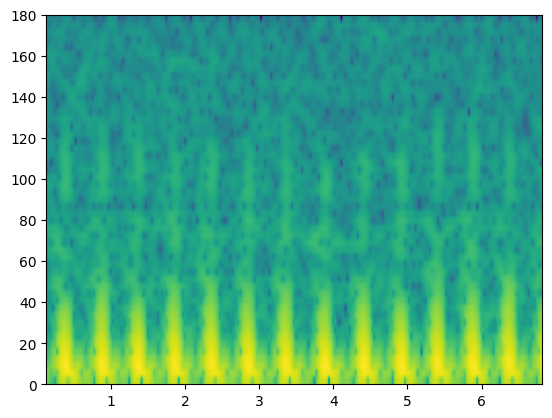

In [8]:
#Parametros
data_path = 'C:\\Users\\jdani\\Desktop\\Trabajo de grado\\BaseDeDatos\\mit_bih_arrhythmiadatabase\\'
FsBaseDatosOriginal = 360 # Frecuencia de muestreo
FsBaseDatosTratada = 250 # Frecuencia de muestreo
Fc = 0.67 # Recomendada en la bibliografia
factor = 2 # Recomendada en la bibliografia
tamano_ventana=10

#primer paciente
senal_ecg_canal_I_Normal,senal_ecg_canal_II_Normal=funcion_filtro_normalizacion_FA('105',data_path,FsBaseDatosOriginal,True)
senal_ecg_ventaneada_canal_I_Normal=senal_ecg_canal_I_Normal[rangos_ventaneo_senal(FsBaseDatosTratada,tamano_ventana,[0,len(senal_ecg_canal_I_Normal)])]
print(senal_ecg_ventaneada_canal_I_Normal.shape)
pxx_I_0=graph_spectrogram(senal_ecg_ventaneada_canal_I_Normal[0],FsBaseDatosOriginal)
print(pxx_I_0.shape)

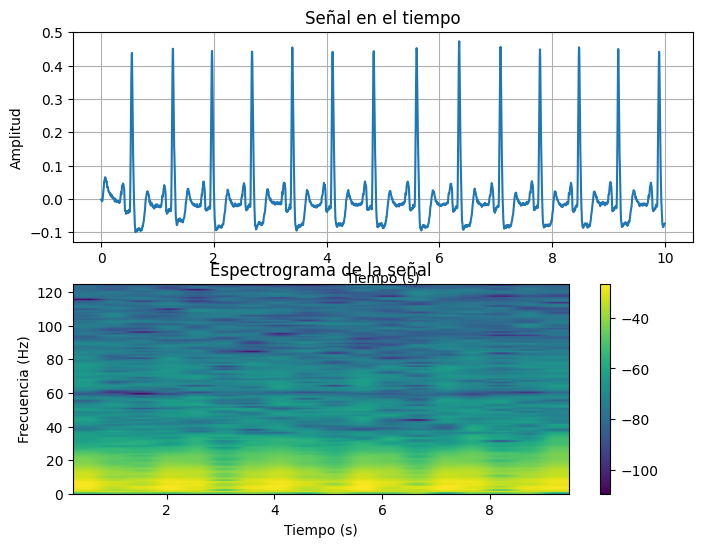

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Generamos una señal de prueba
N = 2500 # Número de puntos de la señal
fs = 250 # Frecuencia de muestreo de la señal (en Hz)
t = np.arange(N) / fs # Vector de tiempo
# f1 = 1000 # Frecuencia de la señal (en Hz)
# s = np.sin(2*np.pi*f1*t) # Señal sinusoidal de frecuencia f1

# Creamos la figura con dos subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

# Graficamos la señal en el tiempo en el primer subplot
ax1.plot(t, senal_ecg_ventaneada_canal_I_Normal[0,:])
ax1.set_xlabel('Tiempo (s)')
ax1.set_ylabel('Amplitud')
ax1.set_title('Señal en el tiempo')
ax1.grid(True)

# Graficamos el espectrograma de la señal en el segundo subplot
im = ax2.specgram(senal_ecg_ventaneada_canal_I_Normal[0,:], Fs=fs)
ax2.set_xlabel('Tiempo (s)')
ax2.set_ylabel('Frecuencia (Hz)')
ax2.set_title('Espectrograma de la señal')
fig.colorbar(im[3], ax=ax2)  # se corrige el error aquí

# Mostramos la figura
plt.show()

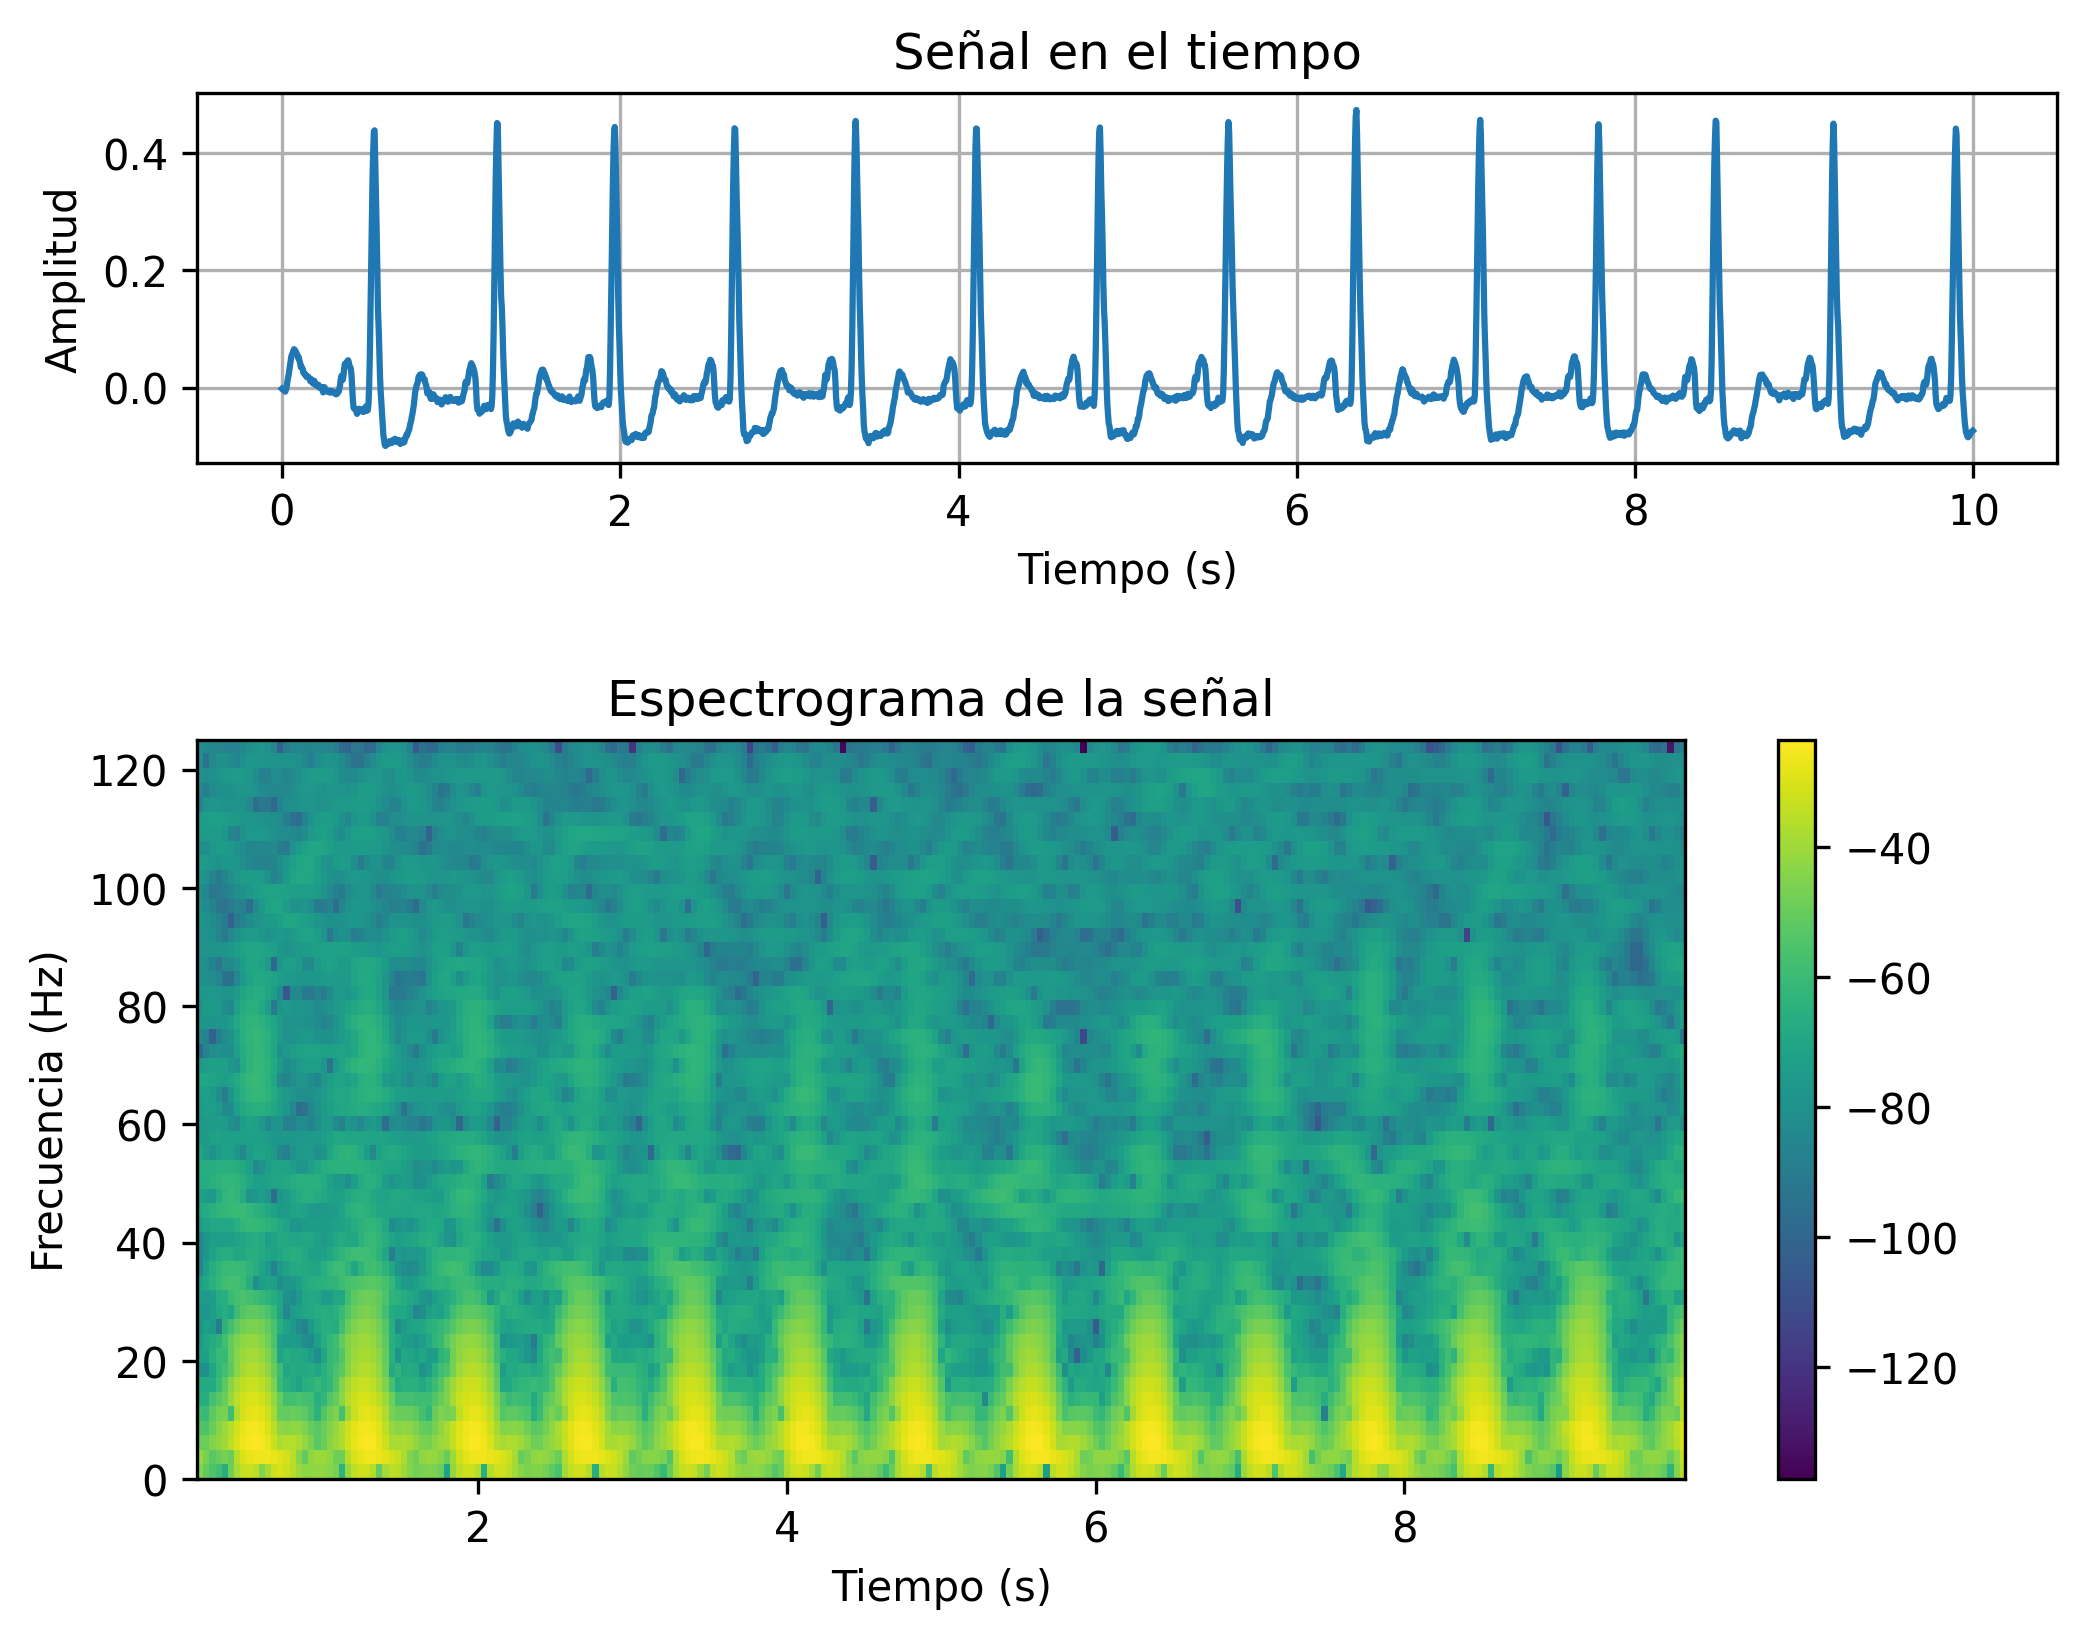

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Generamos una señal de prueba
N = 2500 # Número de puntos de la señal
fs = 250 # Frecuencia de muestreo de la señal (en Hz)
t = np.arange(N) / fs # Vector de tiempo
# f1 = 1000 # Frecuencia de la señal (en Hz)
# s = np.sin(2*np.pi*f1*t) # Señal sinusoidal de frecuencia f1

# Creamos la figura con dos subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), gridspec_kw={'height_ratios': [1, 2]},dpi=300)
fig.subplots_adjust(hspace=0.5)

# Graficamos la señal en el tiempo en el primer subplot
ax1.plot(t, senal_ecg_ventaneada_canal_I_Normal[0,:])
ax1.set_xlabel('Tiempo (s)')
ax1.set_ylabel('Amplitud')
ax1.set_title('Señal en el tiempo')
ax1.grid(True)

# Graficamos el espectrograma de la señal en el segundo subplot
nfft = 100 # Length of each window segment
noverlap = 90 # Overlap between windows
im = ax2.specgram(senal_ecg_ventaneada_canal_I_Normal[0,:], Fs=fs,NFFT=nfft, noverlap = noverlap)
ax2.set_xlabel('Tiempo (s)')
ax2.set_ylabel('Frecuencia (Hz)')
ax2.set_title('Espectrograma de la señal')
fig.colorbar(im[3], ax=ax2)  # se corrige el error aquí

# Mostramos la figura
plt.savefig("ImagenesGuardadas\\Espectrograma.png",dpi=300)
plt.show()

